# Imports

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras import Sequential, metrics, callbacks, layers, losses
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical, image_dataset_from_directory

import tensorflow as tf

from torch.utils.data import Dataset
from cv2 import imread

# Data

In [2]:
root = "glomerulos/"
img_size = (256,256)
channels = 3
img_shape = (img_size[0],img_size[1],channels)
batch_size = 64

In [3]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_size[0], img_size[1]),
  # layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
  #layers.Normalization(),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
  layers.RandomBrightness(0.2),
])
data_augmentation.build(img_shape)

2023-11-19 11:58:00.538270: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-19 11:58:00.538320: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: athena
2023-11-19 11:58:00.538340: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: athena
2023-11-19 11:58:00.538472: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2023-11-19 11:58:00.538502: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-11-19 11:58:00.538511: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


# Model

In [4]:
def createModel(lr: int, fc_layers: list, optim: str, activation="leakyrelu"):
  model = keras.Sequential()
  # Pre-processing and Augmentation
  model.add(resize_and_rescale)
  model.add(data_augmentation)

  # Backbone
  model.add(layers.Conv2D(filters=1,kernel_size=5,strides=(2,2),padding="same",activation=activation,input_shape=img_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D())
        
  model.add(layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding="same",activation=activation,input_shape=img_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D())

  model.add(layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding="same",activation=activation,input_shape=img_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D())

  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(.25))

  # FCs
  if len(fc_layers) < 1:
    raise Exception("É necessário pelo menos uma fully-connected layer")
  
  model.add(layers.Dense(fc_layers[0],activation=activation))
  model.add(layers.BatchNormalization())
  for i in range(1,len(fc_layers)):
    model.add(layers.Dense(fc_layers[i],activation=activation))
    model.add(layers.BatchNormalization())
    if i%3 == 0:
      model.add(layers.Dropout(.25))
  model.add(layers.Dense(4,activation=('softmax')))

  model.build((batch_size,img_size[0],img_size[1],3))
  #model.summary()
  train_metrics = [metrics.CategoricalAccuracy(), metrics.F1Score(average='macro')]
  optims = {
    'Adam': Adam,
    'RMSprop': RMSprop,
    'SGD': SGD,
  }
  model.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optims[optim](learning_rate=lr),
                metrics=train_metrics
                )
  return model

# Hyperbanding

In [5]:
train_set, val_set = image_dataset_from_directory(
    root + "train",
    labels="inferred",
    batch_size=batch_size,
    label_mode="categorical",
    validation_split=.1,
    subset='both',
    seed=20232
)

n_epochs_per_search = 3

learning_rates = [.01,.001,.0001]
fc_layers = [(512,256,128,64),(64,32,16), (256,64), (64,16)]
optimizers = ['SGD', 'RMSprop', 'Adam']


best_loss = 99999
best_loss_cfg = {'lyrs':None, 'optim': None, 'lr': None}
best_acc = 0
best_acc_cfg = {'lyrs':None, 'optim': None, 'lr': None}


for lyrs in fc_layers:
  for optim in optimizers:
    for lr in learning_rates:
      print(f"== [Layers: {lyrs}] [Optim: {optim}] [lr: {lr}] ==")
      model = createModel(lr, lyrs, optim, activation=layers.LeakyReLU())
      model_metrics = model.fit(train_set, validation_data=val_set, epochs=n_epochs_per_search)
      loss = model_metrics.history['val_loss'][-1] # ultimo valor de perda
      val_acc = model_metrics.history['val_categorical_accuracy'][-1] # ultimo valor de acc
      if loss < best_loss:
        print(f"[!] New best loss {best_loss} -> {loss}")
        best_loss_cfg['lyrs'] = lyrs
        best_loss_cfg['optim'] = optim
        best_loss_cfg['lr'] = lr
        best_loss = loss
      if val_acc > best_acc:
        print(f"[!] New best acc {best_acc} -> {val_acc}")
        best_acc_cfg['lyrs'] = lyrs
        best_acc_cfg['optim'] = optim
        best_acc_cfg['lr'] = lr
        best_acc = val_acc

Found 3544 files belonging to 4 classes.
Using 3190 files for training.
Using 354 files for validation.
== [Layers: (512, 256, 128, 64)] [Optim: SGD] [lr: 0.01] ==
Epoch 1/3
50/50 [==============================] - 67s 1s/step - loss: 1.7762 - categorical_accuracy: 0.3157 - f1_score: 0.2955 - val_loss: 3.5368 - val_categorical_accuracy: 0.2571 - val_f1_score: 0.1418
Epoch 2/3
50/50 [==============================] - 57s 1s/step - loss: 1.5203 - categorical_accuracy: 0.3495 - f1_score: 0.3168 - val_loss: 2.6709 - val_categorical_accuracy: 0.2627 - val_f1_score: 0.1730
Epoch 3/3
50/50 [==============================] - 56s 1s/step - loss: 1.4028 - categorical_accuracy: 0.3803 - f1_score: 0.3402 - val_loss: 1.4737 - val_categorical_accuracy: 0.3503 - val_f1_score: 0.3138
[!] New best loss 99999 -> 1.4737192392349243
[!] New best acc 0 -> 0.3502824902534485
== [Layers: (512, 256, 128, 64)] [Optim: SGD] [lr: 0.001] ==
Epoch 1/3
50/50 [==============================] - 60s 1s/step - loss: 2.

In [6]:
best_loss_cfg, best_acc_cfg

({'lyrs': (64, 16), 'optim': 'Adam', 'lr': 0.01},
 {'lyrs': (256, 64), 'optim': 'RMSprop', 'lr': 0.01})

# Training

In [7]:
train_set, val_set = image_dataset_from_directory(
    root + "train",
    labels="inferred",
    batch_size=batch_size,
    label_mode="categorical",
    class_names=('normal', 'crescente', 'esclerose', 'hipercelularidade'),
    validation_split=0.1,
    subset='both',
    seed=20232
)

Found 3544 files belonging to 4 classes.
Using 3190 files for training.
Using 354 files for validation.


In [8]:
for x,y in train_set:
    print(y)
    break

tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]], shape=(64, 4), dtype=float3

In [9]:
epochs=500
cp_dir = "./new-optimized_model"
learn_rate=1e-3

checkpoint = callbacks.ModelCheckpoint(cp_dir,
                            monitor='val_loss', verbose=1,
                            save_best_only=True,
                            mode='auto')

train_callbacks = [callbacks.History(), checkpoint]

In [10]:
model = createModel(best_loss_cfg['lr'], best_loss_cfg['lyrs'], best_loss_cfg['optim'], activation=layers.LeakyReLU())
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_108 (Conv2D)         (64, 128, 128, 1)         76        
                                                                 
 batch_normalization_243 (B  (64, 128, 128, 1)         4         
 atchNormalization)                                              
                                                                 
 max_pooling2d_108 (MaxPool  (64, 64, 64, 1)           0         
 ing2D)                                                          
                                                                 
 conv2d_109 (Conv2D)         (64, 64, 64, 1)         

In [11]:
history=model.fit(
        train_set,
        epochs=epochs,
        shuffle=True,
        validation_data=val_set,
        verbose=1,
        callbacks=train_callbacks,
    )

Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 1.2358 - categorical_accuracy: 0.4611 - f1_score: 0.3633
Epoch 1: val_loss improved from inf to 2.98653, saving model to ./new-optimized_model
INFO:tensorflow:Assets written to: ./new-optimized_model/assets


INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 41s 740ms/step - loss: 1.2358 - categorical_accuracy: 0.4611 - f1_score: 0.3633 - val_loss: 2.9865 - val_categorical_accuracy: 0.2006 - val_f1_score: 0.1322
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 1.1057 - categorical_accuracy: 0.5251 - f1_score: 0.3965
Epoch 2: val_loss improved from 2.98653 to 1.98543, saving model to ./new-optimized_model
INFO:tensorflow:Assets written to: ./new-optimized_model/assets


INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 39s 764ms/step - loss: 1.1057 - categorical_accuracy: 0.5251 - f1_score: 0.3965 - val_loss: 1.9854 - val_categorical_accuracy: 0.3390 - val_f1_score: 0.1692
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 1.0999 - categorical_accuracy: 0.5204 - f1_score: 0.3973
Epoch 3: val_loss improved from 1.98543 to 1.09553, saving model to ./new-optimized_model
INFO:tensorflow:Assets written to: ./new-optimized_model/assets


INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 57s 1s/step - loss: 1.0999 - categorical_accuracy: 0.5204 - f1_score: 0.3973 - val_loss: 1.0955 - val_categorical_accuracy: 0.5847 - val_f1_score: 0.4372
Epoch 4/500
50/50 [==============================] - ETA: 0s - loss: 1.0938 - categorical_accuracy: 0.5270 - f1_score: 0.4086
Epoch 4: val_loss improved from 1.09553 to 0.96965, saving model to ./new-optimized_model
INFO:tensorflow:Assets written to: ./new-optimized_model/assets


INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 40s 785ms/step - loss: 1.0938 - categorical_accuracy: 0.5270 - f1_score: 0.4086 - val_loss: 0.9696 - val_categorical_accuracy: 0.6271 - val_f1_score: 0.4522
Epoch 5/500
50/50 [==============================] - ETA: 0s - loss: 1.0847 - categorical_accuracy: 0.5367 - f1_score: 0.4042
Epoch 5: val_loss did not improve from 0.96965
50/50 [==============================] - 52s 1s/step - loss: 1.0847 - categorical_accuracy: 0.5367 - f1_score: 0.4042 - val_loss: 1.2467 - val_categorical_accuracy: 0.4096 - val_f1_score: 0.2790
Epoch 6/500
50/50 [==============================] - ETA: 0s - loss: 1.0669 - categorical_accuracy: 0.5354 - f1_score: 0.4160
Epoch 6: val_loss did not improve from 0.96965
50/50 [==============================] - 50s 948ms/step - loss: 1.0669 - categorical_accuracy: 0.5354 - f1_score: 0.4160 - val_loss: 1.2222 - val_categorical_accuracy: 0.4718 - val_f1_score: 0.2919
Epoch 7/500
50/50 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 52s 1s/step - loss: 0.9918 - categorical_accuracy: 0.5774 - f1_score: 0.4826 - val_loss: 0.9358 - val_categorical_accuracy: 0.6356 - val_f1_score: 0.4711
Epoch 18/500
50/50 [==============================] - ETA: 0s - loss: 1.0102 - categorical_accuracy: 0.5530 - f1_score: 0.4447
Epoch 18: val_loss did not improve from 0.93584
50/50 [==============================] - 35s 673ms/step - loss: 1.0102 - categorical_accuracy: 0.5530 - f1_score: 0.4447 - val_loss: 1.1671 - val_categorical_accuracy: 0.5000 - val_f1_score: 0.2664
Epoch 19/500
50/50 [==============================] - ETA: 0s - loss: 1.0685 - categorical_accuracy: 0.5323 - f1_score: 0.4181
Epoch 19: val_loss did not improve from 0.93584
50/50 [==============================] - 50s 964ms/step - loss: 1.0685 - categorical_accuracy: 0.5323 - f1_score: 0.4181 - val_loss: 1.1570 - val_categorical_accuracy: 0.5169 - val_f1_score: 0.3924
Epoch 20/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 54s 1s/step - loss: 0.9989 - categorical_accuracy: 0.5649 - f1_score: 0.4629 - val_loss: 0.9051 - val_categorical_accuracy: 0.6130 - val_f1_score: 0.5175
Epoch 24/500
50/50 [==============================] - ETA: 0s - loss: 0.9953 - categorical_accuracy: 0.5721 - f1_score: 0.4715
Epoch 24: val_loss did not improve from 0.90514
50/50 [==============================] - 35s 691ms/step - loss: 0.9953 - categorical_accuracy: 0.5721 - f1_score: 0.4715 - val_loss: 1.0259 - val_categorical_accuracy: 0.5508 - val_f1_score: 0.4699
Epoch 25/500
50/50 [==============================] - ETA: 0s - loss: 0.9885 - categorical_accuracy: 0.5712 - f1_score: 0.4807
Epoch 25: val_loss did not improve from 0.90514
50/50 [==============================] - 51s 967ms/step - loss: 0.9885 - categorical_accuracy: 0.5712 - f1_score: 0.4807 - val_loss: 2.2746 - val_categorical_accuracy: 0.2316 - val_f1_score: 0.1358
Epoch 26/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 53s 1s/step - loss: 0.9908 - categorical_accuracy: 0.5630 - f1_score: 0.4299 - val_loss: 0.9003 - val_categorical_accuracy: 0.6186 - val_f1_score: 0.4702
Epoch 35/500
50/50 [==============================] - ETA: 0s - loss: 0.9945 - categorical_accuracy: 0.5580 - f1_score: 0.4240
Epoch 35: val_loss did not improve from 0.90025
50/50 [==============================] - 35s 688ms/step - loss: 0.9945 - categorical_accuracy: 0.5580 - f1_score: 0.4240 - val_loss: 0.9324 - val_categorical_accuracy: 0.5876 - val_f1_score: 0.4445
Epoch 36/500
50/50 [==============================] - ETA: 0s - loss: 0.9759 - categorical_accuracy: 0.5671 - f1_score: 0.4328
Epoch 36: val_loss did not improve from 0.90025
50/50 [==============================] - 50s 958ms/step - loss: 0.9759 - categorical_accuracy: 0.5671 - f1_score: 0.4328 - val_loss: 1.3179 - val_categorical_accuracy: 0.4294 - val_f1_score: 0.2611
Epoch 37/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 53s 1s/step - loss: 0.9749 - categorical_accuracy: 0.5715 - f1_score: 0.4485 - val_loss: 0.8712 - val_categorical_accuracy: 0.6130 - val_f1_score: 0.4884
Epoch 43/500
50/50 [==============================] - ETA: 0s - loss: 0.9489 - categorical_accuracy: 0.5918 - f1_score: 0.4776
Epoch 43: val_loss did not improve from 0.87121
50/50 [==============================] - 35s 674ms/step - loss: 0.9489 - categorical_accuracy: 0.5918 - f1_score: 0.4776 - val_loss: 1.0618 - val_categorical_accuracy: 0.4915 - val_f1_score: 0.4103
Epoch 44/500
50/50 [==============================] - ETA: 0s - loss: 0.9570 - categorical_accuracy: 0.5834 - f1_score: 0.4662
Epoch 44: val_loss did not improve from 0.87121
50/50 [==============================] - 51s 972ms/step - loss: 0.9570 - categorical_accuracy: 0.5834 - f1_score: 0.4662 - val_loss: 1.0350 - val_categorical_accuracy: 0.5141 - val_f1_score: 0.3888
Epoch 45/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 53s 1s/step - loss: 0.9290 - categorical_accuracy: 0.6113 - f1_score: 0.5155 - val_loss: 0.8495 - val_categorical_accuracy: 0.6610 - val_f1_score: 0.5897
Epoch 64/500
50/50 [==============================] - ETA: 0s - loss: 0.9148 - categorical_accuracy: 0.6100 - f1_score: 0.5199
Epoch 64: val_loss did not improve from 0.84945
50/50 [==============================] - 34s 664ms/step - loss: 0.9148 - categorical_accuracy: 0.6100 - f1_score: 0.5199 - val_loss: 0.9423 - val_categorical_accuracy: 0.5734 - val_f1_score: 0.4826
Epoch 65/500
50/50 [==============================] - ETA: 0s - loss: 0.9214 - categorical_accuracy: 0.6053 - f1_score: 0.5130
Epoch 65: val_loss did not improve from 0.84945
50/50 [==============================] - 51s 968ms/step - loss: 0.9214 - categorical_accuracy: 0.6053 - f1_score: 0.5130 - val_loss: 1.4420 - val_categorical_accuracy: 0.4237 - val_f1_score: 0.1940
Epoch 66/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 53s 1s/step - loss: 0.9168 - categorical_accuracy: 0.6038 - f1_score: 0.5101 - val_loss: 0.8166 - val_categorical_accuracy: 0.6751 - val_f1_score: 0.5739
Epoch 88/500
50/50 [==============================] - ETA: 0s - loss: 0.9107 - categorical_accuracy: 0.6179 - f1_score: 0.5371
Epoch 88: val_loss improved from 0.81656 to 0.81533, saving model to ./new-optimized_model
INFO:tensorflow:Assets written to: ./new-optimized_model/assets


INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 41s 801ms/step - loss: 0.9107 - categorical_accuracy: 0.6179 - f1_score: 0.5371 - val_loss: 0.8153 - val_categorical_accuracy: 0.6751 - val_f1_score: 0.5883
Epoch 89/500
50/50 [==============================] - ETA: 0s - loss: 0.9179 - categorical_accuracy: 0.6069 - f1_score: 0.5199
Epoch 89: val_loss did not improve from 0.81533
50/50 [==============================] - 53s 1s/step - loss: 0.9179 - categorical_accuracy: 0.6069 - f1_score: 0.5199 - val_loss: 3.0301 - val_categorical_accuracy: 0.3390 - val_f1_score: 0.1718
Epoch 90/500
50/50 [==============================] - ETA: 0s - loss: 0.9108 - categorical_accuracy: 0.6141 - f1_score: 0.5356
Epoch 90: val_loss did not improve from 0.81533
50/50 [==============================] - 49s 949ms/step - loss: 0.9108 - categorical_accuracy: 0.6141 - f1_score: 0.5356 - val_loss: 1.5231 - val_categorical_accuracy: 0.5056 - val_f1_score: 0.3533
Epoch 91/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 54s 1s/step - loss: 0.9049 - categorical_accuracy: 0.6135 - f1_score: 0.5191 - val_loss: 0.7986 - val_categorical_accuracy: 0.6780 - val_f1_score: 0.5967
Epoch 93/500
50/50 [==============================] - ETA: 0s - loss: 0.8997 - categorical_accuracy: 0.6160 - f1_score: 0.5408
Epoch 93: val_loss did not improve from 0.79862
50/50 [==============================] - 33s 646ms/step - loss: 0.8997 - categorical_accuracy: 0.6160 - f1_score: 0.5408 - val_loss: 0.8803 - val_categorical_accuracy: 0.6328 - val_f1_score: 0.5966
Epoch 94/500
50/50 [==============================] - ETA: 0s - loss: 0.9063 - categorical_accuracy: 0.6103 - f1_score: 0.5283
Epoch 94: val_loss did not improve from 0.79862
50/50 [==============================] - 51s 980ms/step - loss: 0.9063 - categorical_accuracy: 0.6103 - f1_score: 0.5283 - val_loss: 0.9859 - val_categorical_accuracy: 0.5734 - val_f1_score: 0.5121
Epoch 95/500
50/50 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 53s 1s/step - loss: 0.8717 - categorical_accuracy: 0.6257 - f1_score: 0.5458 - val_loss: 0.7859 - val_categorical_accuracy: 0.6695 - val_f1_score: 0.5883
Epoch 203/500
50/50 [==============================] - ETA: 0s - loss: 0.8834 - categorical_accuracy: 0.6266 - f1_score: 0.5523
Epoch 203: val_loss did not improve from 0.78590
50/50 [==============================] - 35s 685ms/step - loss: 0.8834 - categorical_accuracy: 0.6266 - f1_score: 0.5523 - val_loss: 0.8879 - val_categorical_accuracy: 0.6271 - val_f1_score: 0.5672
Epoch 204/500
50/50 [==============================] - ETA: 0s - loss: 0.8715 - categorical_accuracy: 0.6307 - f1_score: 0.5542
Epoch 204: val_loss did not improve from 0.78590
50/50 [==============================] - 51s 969ms/step - loss: 0.8715 - categorical_accuracy: 0.6307 - f1_score: 0.5542 - val_loss: 0.8983 - val_categorical_accuracy: 0.6469 - val_f1_score: 0.5446
Epoch 205/500
50/50 [==============================] - 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 53s 1s/step - loss: 0.8635 - categorical_accuracy: 0.6367 - f1_score: 0.5619 - val_loss: 0.7772 - val_categorical_accuracy: 0.7147 - val_f1_score: 0.6748
Epoch 301/500
50/50 [==============================] - ETA: 0s - loss: 0.8526 - categorical_accuracy: 0.6417 - f1_score: 0.5701
Epoch 301: val_loss did not improve from 0.77724
50/50 [==============================] - 35s 692ms/step - loss: 0.8526 - categorical_accuracy: 0.6417 - f1_score: 0.5701 - val_loss: 1.2977 - val_categorical_accuracy: 0.4972 - val_f1_score: 0.3898
Epoch 302/500
50/50 [==============================] - ETA: 0s - loss: 0.8352 - categorical_accuracy: 0.6451 - f1_score: 0.5738
Epoch 302: val_loss did not improve from 0.77724
50/50 [==============================] - 50s 966ms/step - loss: 0.8352 - categorical_accuracy: 0.6451 - f1_score: 0.5738 - val_loss: 0.9507 - val_categorical_accuracy: 0.5960 - val_f1_score: 0.5466
Epoch 303/500
50/50 [==============================] - 

INFO:tensorflow:Assets written to: ./new-optimized_model/assets


50/50 [==============================] - 55s 1s/step - loss: 0.8377 - categorical_accuracy: 0.6423 - f1_score: 0.5730 - val_loss: 0.7696 - val_categorical_accuracy: 0.6921 - val_f1_score: 0.6410
Epoch 429/500
50/50 [==============================] - ETA: 0s - loss: 0.8382 - categorical_accuracy: 0.6342 - f1_score: 0.5699
Epoch 429: val_loss did not improve from 0.76964
50/50 [==============================] - 36s 692ms/step - loss: 0.8382 - categorical_accuracy: 0.6342 - f1_score: 0.5699 - val_loss: 0.8948 - val_categorical_accuracy: 0.6271 - val_f1_score: 0.5573
Epoch 430/500
50/50 [==============================] - ETA: 0s - loss: 0.8537 - categorical_accuracy: 0.6423 - f1_score: 0.5638
Epoch 430: val_loss did not improve from 0.76964
50/50 [==============================] - 50s 956ms/step - loss: 0.8537 - categorical_accuracy: 0.6423 - f1_score: 0.5638 - val_loss: 22.5938 - val_categorical_accuracy: 0.2966 - val_f1_score: 0.1144
Epoch 431/500
50/50 [==============================] -

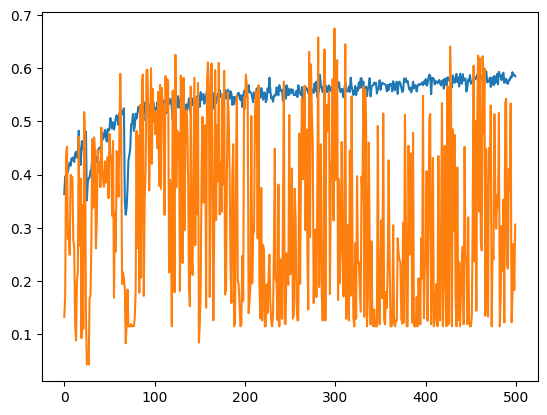

In [13]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

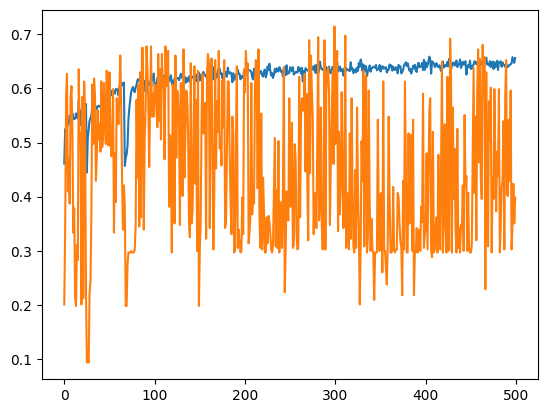

In [15]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

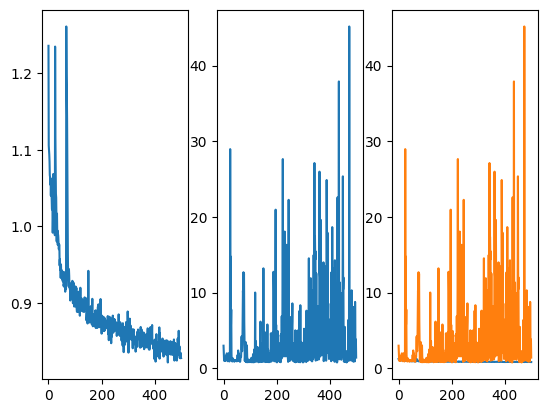

In [23]:
plt.subplot(1,3,1)
plt.plot(history.history['loss'])

plt.subplot(1,3,2)
plt.plot(history.history['val_loss'])

plt.subplot(1,3,3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [25]:
np.save("new-optimized_model/history.np", history)

# Testing

In [72]:
import datetime, os
from keras.utils import load_img, img_to_array
from PIL import Image

In [56]:
model.load_weights("./new-optimized_model/")

2023-11-20 10:18:07.509625: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./new-optimized_model/: FAILED_PRECONDITION: new-optimized_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [57]:
test_set = os.listdir(root+'test')
print(len(test_set))

1771


In [103]:
predictions = {}
for fpath in test_set:
    fname = fpath[:fpath.rfind('.')] + '.' + fpath[fpath.rfind('.')+1:].lower()
    img = img_to_array(load_img(root+'test/'+fpath))
    img.resize(1,256,256,3)
    predictions[fname] = model.predict([img], verbose=0).argmax(1).item() + 1
predictions


{'6KdKSJhe.jpg': 2,
 'db9dITKU.jpg': 4,
 'snztamXy.jpg': 4,
 '2eZrO72x.jpg': 3,
 'VYpVxS55.jpg': 4,
 '7ETtihnx.jpg': 4,
 'yyEyUzbo.jpg': 1,
 'OXbk1MpW.jpg': 2,
 'IfmYQuqF.jpg': 4,
 'CNoFFqcb.jpg': 3,
 'cF5iONH8.jpg': 4,
 'c6vF0XQE.jpg': 2,
 'IvbIB42G.jpg': 2,
 'v7OFUAwb.jpg': 2,
 'zJelrsPT.jpg': 4,
 'mA1uK8Um.jpg': 4,
 'KWj7wLIU.jpg': 4,
 'b7TyAceI.jpg': 4,
 'UvtBNcXF.jpg': 4,
 'H5mbKdeH.jpg': 2,
 'l0YQSzGL.jpg': 2,
 '0lJTlW8w.jpg': 4,
 'hrxspBol.jpg': 2,
 'HIXMqOwY.jpg': 2,
 'JjNGdMtL.jpg': 2,
 'Y2EBMQwT.jpg': 2,
 'HS0upfnC.jpg': 4,
 'Fj4Vdq7k.jpg': 1,
 'VUBJPuLw.jpg': 4,
 'Lxr0ymH8.jpg': 4,
 'OmY0xfMr.jpg': 1,
 'XS4pAzib.jpg': 2,
 'Jb1j6ib5.jpg': 2,
 '3VD8b9Rz.jpg': 4,
 'xomn0BtP.jpg': 1,
 'Dv8xtQUw.jpg': 2,
 'ztY3oGlQ.jpg': 1,
 'EQPqNqS9.jpg': 4,
 'KqZmAJqb.jpg': 2,
 'iR0rZYHd.jpg': 2,
 'JZ9QU7Ky.jpg': 1,
 'MqUeNeBs.jpg': 1,
 'BPKhGsp5.jpg': 2,
 'ytopkKMq.jpg': 2,
 'yNhWI12C.jpg': 2,
 'flPUKRvH.jpg': 4,
 'ot1OMeoY.jpg': 4,
 '3tKaXQ3D.jpg': 2,
 'p0twGbcY.jpg': 4,
 '9ClAEHCy.jpg': 1,


In [109]:
with open(f"submission-{datetime.date.today()}.csv", "w+") as out:
    with open("glomerulos/extra-files/sample-submission.csv.csv", 'r') as sample:
        for i,line in enumerate(sample.readlines()):
            if i == 0:
                out.writelines(line)
                continue
            else:
                out.writelines(line[:-1] + ',' + str(predictions[line[:-1]]) + '\n')